In [76]:
import openaq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aqtools import aqutils as u
api = openaq.OpenAQ()

In [60]:
status, resp = api.measurements(city = 'San Francisco-Oakland-Fremont', location='Oakland', parameter=['pm25','co', 'no2','o3'], limit=5000)
r = resp['results']
df = pd.DataFrame(data=r)

dates = []
for date in df['date'].values:
    local_date = date['local']
    d = u.cleaning_date(local_date)
    dates.append(d)
df['date'] = dates
df = df.reindex(columns=['parameter', 'value', 'date'])
df = df.pivot(index='date', columns='parameter', values='value')
df = df.dropna()
df

parameter,co,no2,o3,pm25
date,,,,
2022-01-10 00:00:00,0.51,0.013,0.006,18.0
2022-01-10 02:00:00,0.33,0.004,0.017,8.0
2022-01-10 04:00:00,0.47,0.016,0.004,9.0
2022-01-10 05:00:00,0.62,0.020,0.000,16.0
2022-01-10 06:00:00,0.81,0.021,0.000,17.0
...,...,...,...,...
2022-05-10 02:00:00,0.24,0.004,0.033,5.0
2022-05-10 03:00:00,0.31,0.009,0.018,2.0
2022-05-10 05:00:00,0.37,0.013,0.013,5.0


/tmp/ipykernel_8105/2430566074.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co'] = co_standardized
/tmp/ipykernel_8105/2430566074.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no2'] = no2_standardized
/tmp/ipykernel_8105/2430566074.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

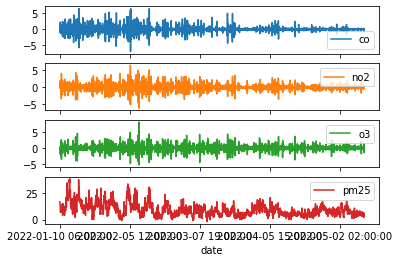

In [66]:
# Standardization
co = df['co'].values
co_standardized = (co - co.mean()) / co.std()
df['co'] = co_standardized

no2 = df['no2'].values
no2_standardized = (no2 - no2.mean()) / no2.std()
df['no2'] = no2_standardized

o3 = df['o3'].values
o3_standardized = (o3 - o3.mean()) / o3.std()
df['o3'] = o3_standardized
df.plot(subplots=True)
plt.show()


/tmp/ipykernel_8105/1345606581.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co'] = co_diff
/tmp/ipykernel_8105/1345606581.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no2'] = no2_diff
/tmp/ipykernel_8105/1345606581.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

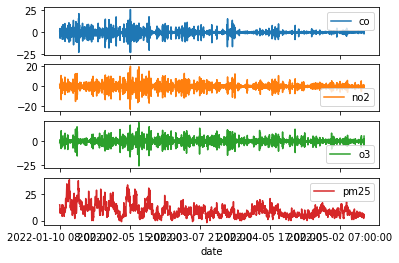

In [68]:
# Make data stationary
co_diff = u.differencing(df['co'].values)
no2_diff = u.differencing(df['no2'].values)
o3_diff = u.differencing(df['o3'].values)

# Delete the first row
df = df.iloc[1:, :]

df['co'] = co_diff
df['no2'] = no2_diff
df['o3'] = o3_diff
df.plot(subplots=True)
plt.show()

In [77]:
# feature vectors
feature_np = df.to_numpy()[:, :3]
# label
label_np = df.to_numpy()[:, -1]

feature_list = []
label_list = []
for i in range(len(feature_np) - 24):
    feature_list.append(feature_np[i:i+24])
    label_list.append(label_np[i+24])

X, y = np.array(feature_list), np.array(label_list)
X.shape, y.shape

AttributeError: module 'aqtools.aqutils' has no attribute 'make_dataset'

In [43]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 200
WINDOW_SIZE = 24

X_train = X[:-TEST_SIZE]
y_train = y[:-TEST_SIZE]
X_test = X[-TEST_SIZE:]
y_test = y[-TEST_SIZE:]


X_train.shape, X_test.shape

((1956, 24, 3), (200, 24, 3))

In [53]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout

model = Sequential()
model.add(GRU(units=50, activation="relu", return_sequences=True, input_shape = X_train[0].shape))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 24, 50)            8250      
                                                                 
 dropout_7 (Dropout)         (None, 24, 50)            0         
                                                                 
 dense_3 (Dense)             (None, 24, 1)             51        
                                                                 
Total params: 8,301
Trainable params: 8,301
Non-trainable params: 0
_________________________________________________________________


In [54]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=48, callbacks=[early_stop])

Epoch 1/100
41/41 [==============================] - 4s 64ms/step - loss: 108.7612 - mae: 8.5059 - val_loss: 33.8382 - val_mae: 4.9136
Epoch 2/100
41/41 [==============================] - 1s 20ms/step - loss: 62.9125 - mae: 6.0013 - val_loss: 20.4778 - val_mae: 3.6214
Epoch 3/100
41/41 [==============================] - 1s 20ms/step - loss: 51.1624 - mae: 5.3837 - val_loss: 18.3051 - val_mae: 3.4745
Epoch 4/100
41/41 [==============================] - 1s 20ms/step - loss: 46.2324 - mae: 5.1333 - val_loss: 15.5353 - val_mae: 3.1804
Epoch 5/100
41/41 [==============================] - 1s 21ms/step - loss: 43.7973 - mae: 4.9843 - val_loss: 16.1305 - val_mae: 3.3049
Epoch 6/100
41/41 [==============================] - 1s 21ms/step - loss: 42.6245 - mae: 4.9288 - val_loss: 15.9691 - val_mae: 3.3016
Epoch 7/100
41/41 [==============================] - 1s 22ms/step - loss: 41.8666 - mae: 4.8957 - val_loss: 15.1217 - val_mae: 3.2045
Epoch 8/100
41/41 [==============================] - 1s 21ms/

In [56]:
# pred = model.predict(X_test)
# print(pred.shape)
# plt.figure(figsize=(12,6))
# plt.plot(y_test, label='actual')
# plt.plot(pred, label='prediction')
# plt.grid()
# plt.legend(loc='best')
# plt.show()
mse,mae = model.evaluate(X_test,y_test,batch_size=48)

5/5 [==============================] - 0s 7ms/step - loss: 15.4563 - mae: 3.2759


In [50]:
pred[0]

array([[9.076301 ],
       [9.318673 ],
       [9.38997  ],
       [9.397708 ],
       [9.382081 ],
       [9.335633 ],
       [9.310672 ],
       [9.424713 ],
       [9.427144 ],
       [9.414912 ],
       [9.412061 ],
       [9.4035845],
       [9.395853 ],
       [9.399213 ],
       [9.410685 ],
       [9.424859 ],
       [9.440701 ],
       [9.457319 ],
       [9.4896   ],
       [9.513261 ],
       [9.566259 ],
       [9.583036 ],
       [9.594165 ],
       [9.600193 ]], dtype=float32)